# Inference with Enformer

In [16]:
import torch
from enformer_pytorch import from_pretrained
import pandas as pd
import numpy as np
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyBigWig


class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
    

def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()


def get_targets(organism):
  targets_txt = f'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_{organism}.txt'
  return pd.read_csv(targets_txt, sep='\t')

## Visualize an output

In [4]:
# Get the model
enformer = from_pretrained('EleutherAI/enformer-official-rough', use_tf_gamma = False).cuda()
enformer.eval()

Enformer(
  (stem): Sequential(
    (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Residual(
      (fn): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (2): AttentionPool(
      (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
      (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (conv_tower): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stri

In [5]:
# Set up the data
SEQUENCE_LENGTH = 196608
fasta_extractor = FastaStringExtractor("/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa")

In [6]:
# Get the sequence
target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430)
sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
sequence_one_hot = torch.tensor(sequence_one_hot).unsqueeze(0)
sequence_one_hot.shape

torch.Size([1, 196608, 4])

In [7]:
# function to clear GPU memory
import gc
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Allocated: {round(torch.cuda.memory_allocated(0)/1024**3,1)}GB")
clear_gpu_memory()

Allocated: 0.9GB


In [12]:
with torch.no_grad():
    predictions = enformer(sequence_one_hot[0].cuda())["human"].detach().cpu().numpy()

In [25]:
# Get h1-hesc DNase-seq signal
bw_file = "/cellar/users/aklie/data/datasets/ENCODE_examples/processed/2024_01_01/DNase-seq/H1-hESC/ENCFF573NKX.bigWig"
file = pyBigWig.open(str(bw_file))
count_vals = np.array(file.values(target_interval.chrom, target_interval.start, target_interval.end))
count_vals = np.nan_to_num(count_vals)

# Bin this into 128 wide bins by summing
count_vals = count_vals.reshape(-1, 128).sum(axis=1)
file.close()

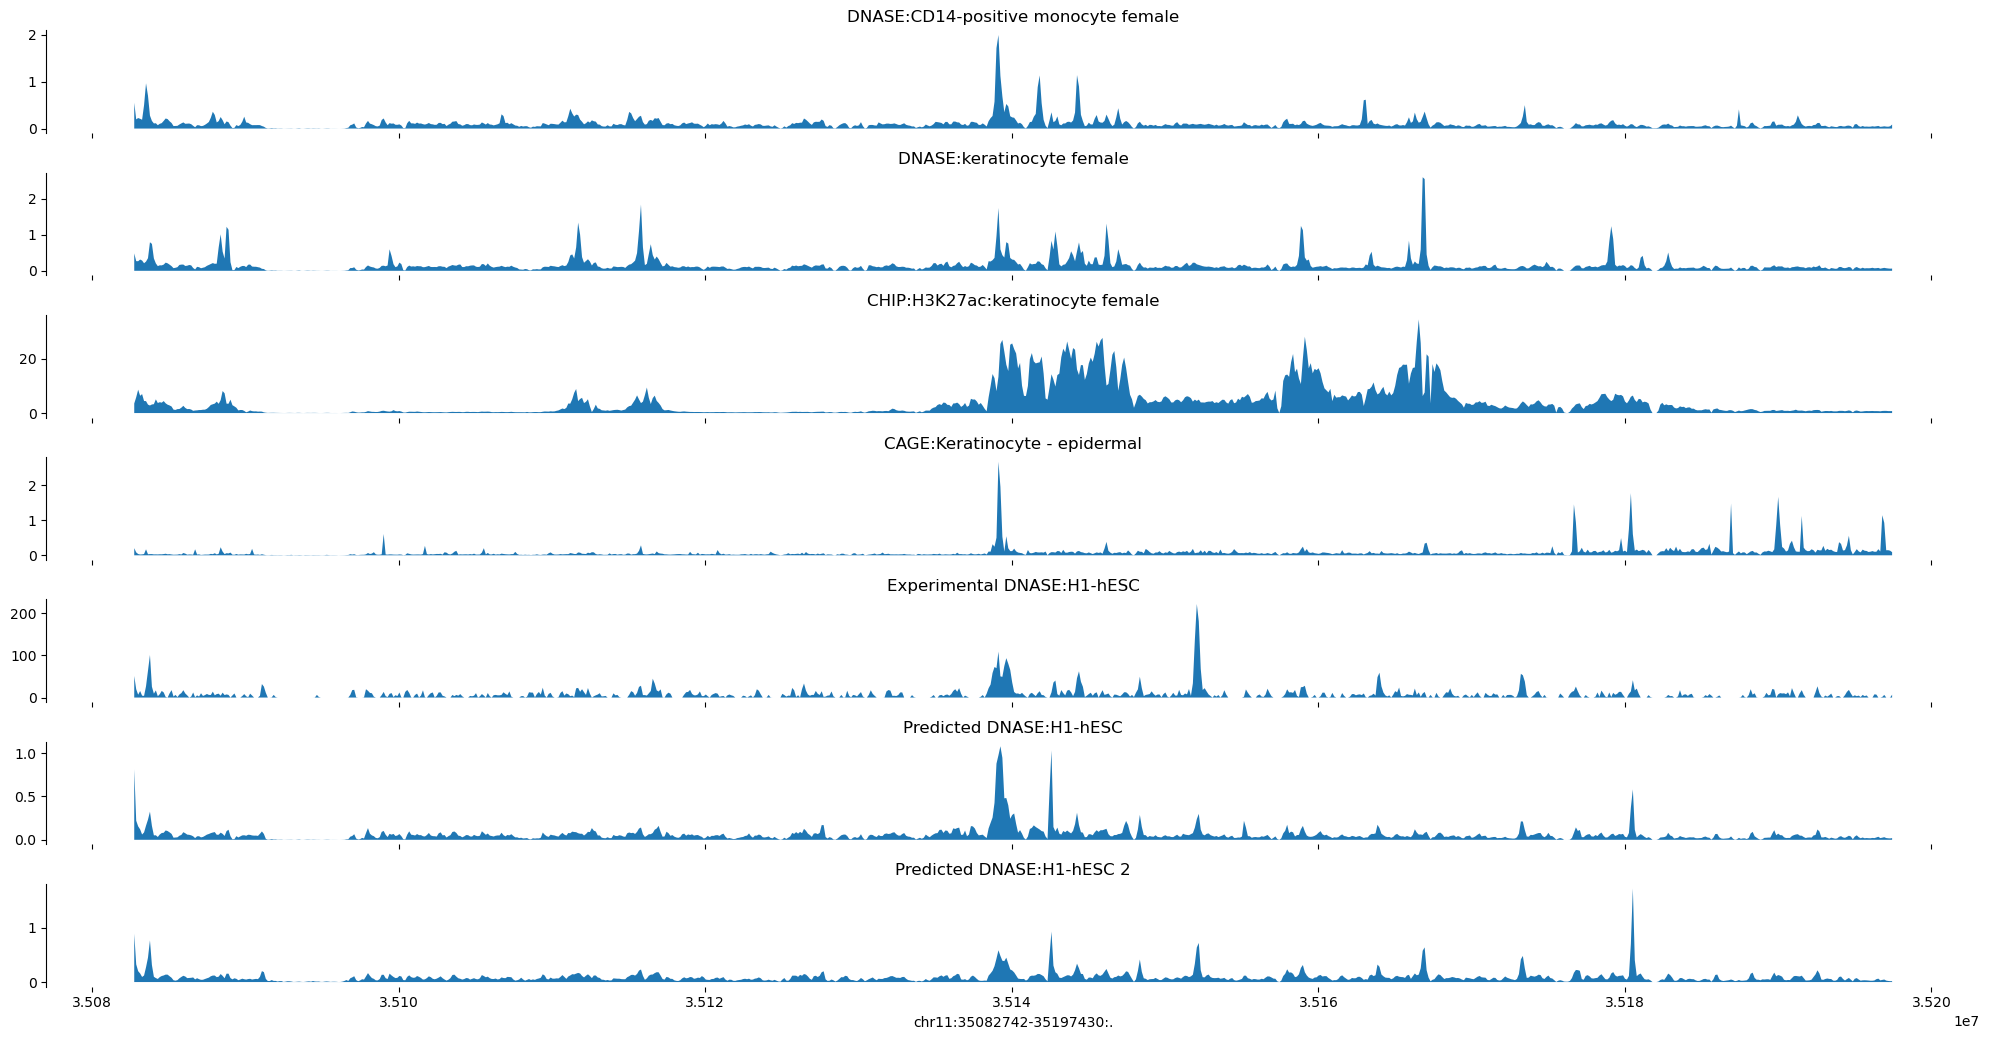

In [32]:
# @title Plot tracks
tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799]),
          'Experimental DNASE:H1-hESC': count_vals,
          'Predicted DNASE:H1-hESC': predictions[:, 19],
          'Predicted DNASE:H1-hESC 2': predictions[:, 70],
          'Predicted DNASE:H1-hESC 2': predictions[:, 70],
}
plot_tracks(tracks, target_interval)

# DONE!

---

## Test Enformer with random weights

In [ ]:
from enformer_pytorch import Enformer, seq_indices_to_one_hot

In [ ]:
# Get PyTorch enformer model from passed in hparams
model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)
model

Enformer(
  (stem): Sequential(
    (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Residual(
      (fn): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (2): AttentionPool(
      (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
      (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (conv_tower): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stri

In [ ]:
# Create a random sequence of length 196,608bps as input
seq = torch.randint(0, 5, (1, 196_608)) # for ACGTN, in that order (-1 for padding)
one_hot = seq_indices_to_one_hot(seq)
seq.shape, one_hot.shape

(torch.Size([1, 196608]), torch.Size([1, 196608, 4]))

In [ ]:
# Get an output from the model
output = model(seq)

In [ ]:
# Get head specific outputs
example_hs_out = output['human'] # (1, 896, 5313)
example_mm_out = output['mouse'] # (1, 896, 1643)
example_hs_out.shape, example_mm_out.shape

(torch.Size([1, 896, 5313]), torch.Size([1, 896, 1643]))

## Test pretrained model performance

In [ ]:
from enformer_pytorch import from_pretrained

/cellar/users/aklie/opt/miniconda3/envs/enformer-pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
enformer = from_pretrained('EleutherAI/enformer-official-rough', use_tf_gamma = False).cuda()
enformer.eval()

Enformer(
  (stem): Sequential(
    (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Residual(
      (fn): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (2): AttentionPool(
      (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
      (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (conv_tower): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stri

In [ ]:
data = torch.load('/cellar/users/aklie/opt/enformer-pytorch/data/test-sample.pt')
seq, target = data['sequence'].cuda(), data['target'].cuda()

In [ ]:
with torch.no_grad():
    corr_coef = enformer(
        seq,
        target = target,
        return_corr_coef = True,
        head = 'human'
    )

print(corr_coef)
assert corr_coef > 0.1

tensor(0.5963, device='cuda:0')


## Test with enformer-pytorch loading

In [ ]:
import polars as pl
from enformer_pytorch import GenomeIntervalDataset

In [ ]:
ds = GenomeIntervalDataset(
    bed_file = '/cellar/users/aklie/data/datasets/ENCODE_ATAC-seq/processed/2023_12_30/ENCFF766BZE.bed',
    fasta_file = '/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa',
    return_seq_indices = False,
    context_length = 196_608,
)

In [28]:
track_config = pd.read_csv("/cellar/users/aklie/data/datasets/ENCODE_examples/bin/data_acquisition/enformer_targets_human.txt", sep="\t")
track_config.head()

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348


In [29]:
ind = track_config[track_config["description"] == "DNASE:H1-hESC"]["index"].values

In [30]:
ind

array([ 19,  70, 565])

In [ ]:
outs = human_out[:, ind]

In [ ]:
outs.shape

torch.Size([896, 2])

In [ ]:
binned_cov = outs[:, 0].detach().cpu().numpy()

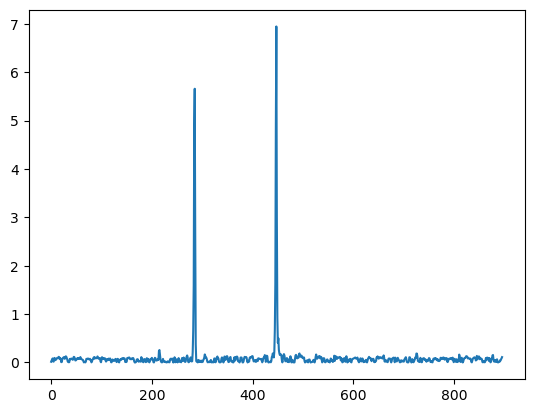

In [ ]:
plt.plot(binned_cov)